In [1]:
import os 
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [2]:

from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle
import matplotlib

In [3]:
mode = "frequencies"

In [5]:
def load_liks(itraj, mode="damping", dtt=1e-6, total_time_in=6.):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l1  = logliks[:,0] - logliks[:,1]
    
    pars = give_def_params_discrimination(flip=1, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l0  = logliks[:,1] - logliks[:,0]
      
    return l0, l1

In [6]:
dt = 1e-4
T = total_time = 200.
ppp=5*1e3

pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

total_time, dt = get_total_time_dt(params, dt=dt, total_time=T, ppp=ppp)
times = np.arange(0, total_time+ dt, dt)

indislog = np.logspace(1,np.log10(len(times)-1), int(1e5))
indislog = [int(k) for k in indislog]
timindlog = [times[ind] for ind in indislog]

In [12]:
ll1 = []
for itraj in range(1,10):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode, dtt=dt, total_time_in=total_time)
    ll1.append(log_lik_ratio)


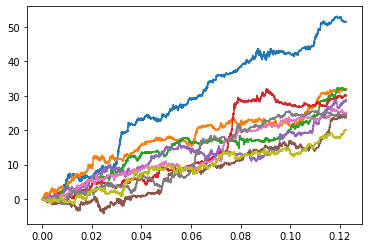

In [13]:
for k in range(9):
    plt.plot(timindlog, ll1[k])

In [24]:
Ntraj = 1000
boundsB= np.arange(-6.1,6.1,.2)

stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(timindlog)))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))


n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode, dtt=dt, total_time_in=total_time)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, timindlog))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,timindlog))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b


                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0

                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
       ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:48<00:00,  9.21it/s]


In [25]:

alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)

times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]


stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

avg_times = 0.5*(avg_times0 + avg_times1)

stoch = avg_times

avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

In [29]:
cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(bpos):
    counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    

/tmp/ipykernel_59179/4020109435.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
/tmp/ipykernel_59179/4020109435.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)


(LOADING PROGRAM)

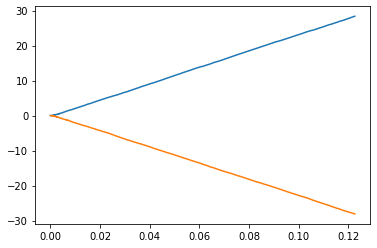

In [30]:
plt.plot(timindlog,l1)
plt.plot(timindlog,l0)

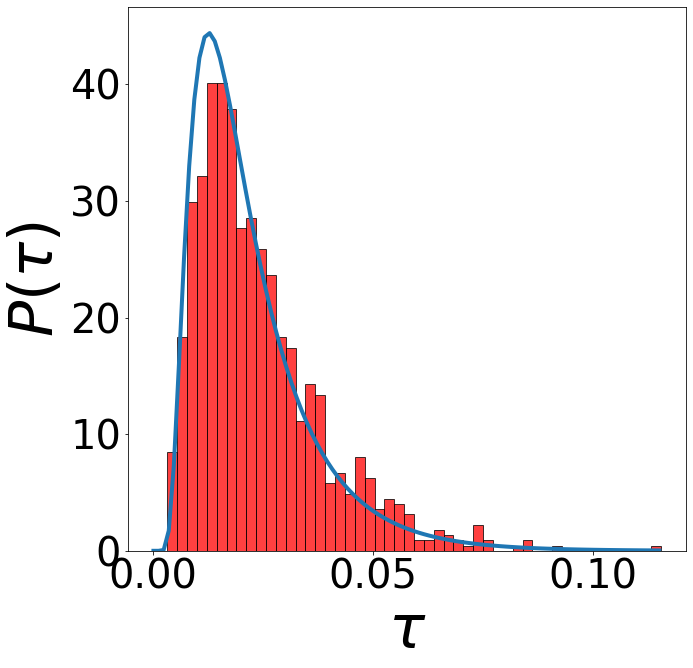

In [40]:
def prob_craft(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1, mu=None):
    
    S= np.sqrt(2*mu)

    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div


muu = l1[-1]/timindlog[-1]

LS, TS = 60, 40
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
indb = -5

timm =  np.linspace(np.min(timbin1),np.max(timbin1),100)

popo = [prob_craft(tt, bpos[indb], kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1, mu=muu) for tt in timm]
ax.plot(timm,popo, linewidth=4)
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

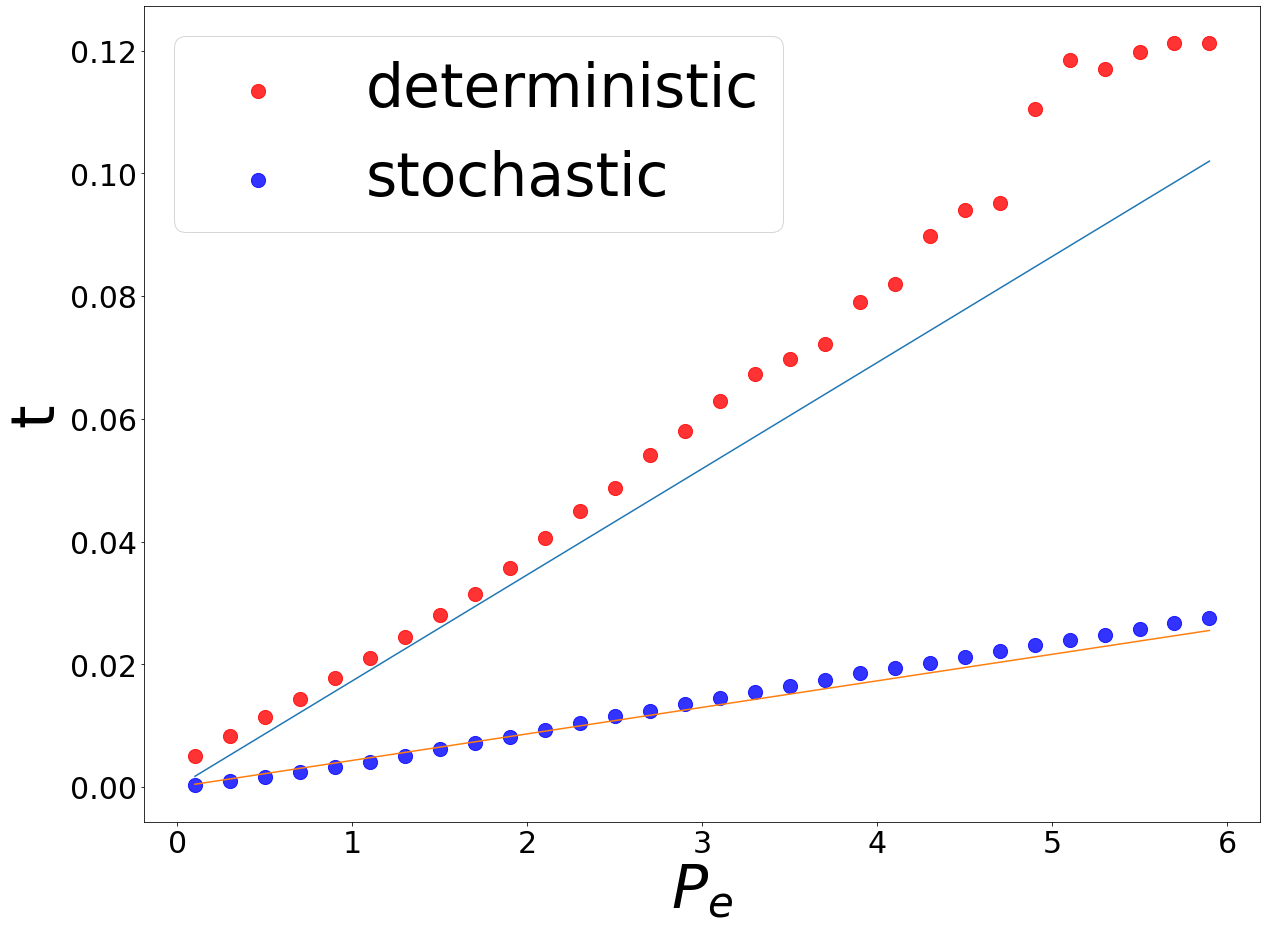

In [41]:

fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
lw=10
TS=30
mm = l1[-1]/timindlog[-1]

ax.scatter(bpos, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(bpos, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")
ax.plot(bpos, 4*bpos/mm)
ax.plot(bpos, bpos/mm)

#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
#ax.set_xscale("log")
#ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"freq_adaptive_vs_det.pdf")




In [42]:
#with open(path_data+"stop.pickle","rb") as f:
 #   stop = pickle.load( f)#, protocol=pickle.HIGHEST_PROTOCOL)

#with open(path_data+"deter.pickle","rb") as f:
#    deter = pickle.load(f)#, protocol=pickle.HIGHEST_PROTOCOL)
    
alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)




bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)
times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

stoch = avg_times

avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

Text(0, 0.5, '$\\frac{t_{det}}{t_{stoch}}$')

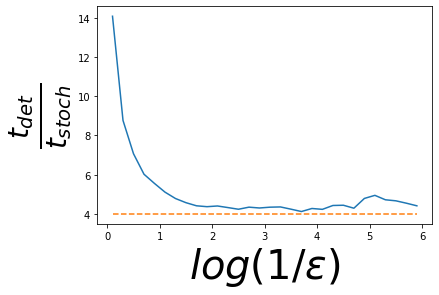

In [67]:
plt.plot(bpos,(times_alpha_to_errB/stoch)[-30:])
plt.plot(bpos,4*np.ones(len(stoch)),'--')
plt.xlabel(r'$log(1/\epsilon)$', size=40)
plt.ylabel(r'$\frac{t_{det}}{t_{stoch}}$', size=40)

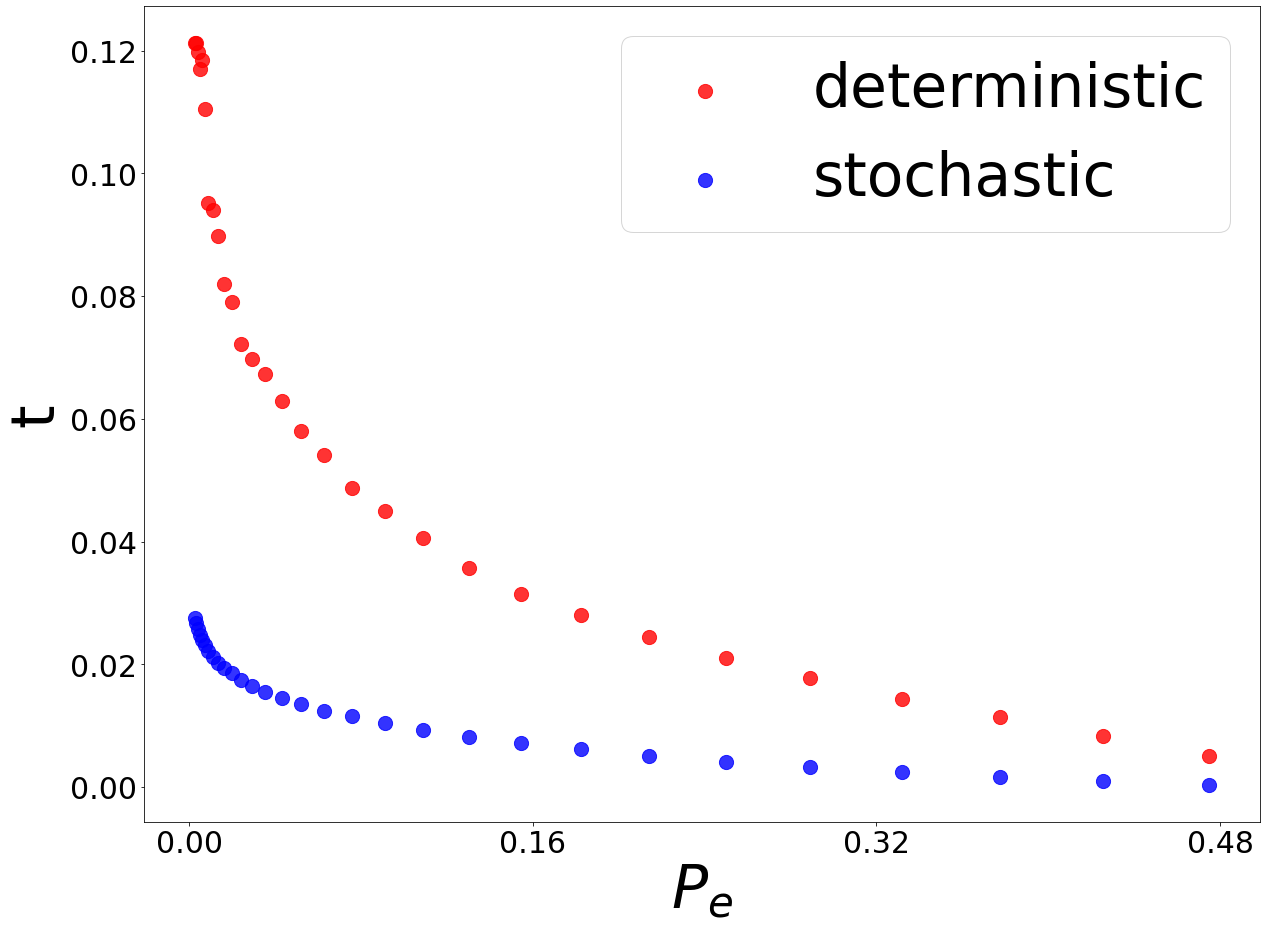

In [61]:

fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
lw=10
TS=30
ax.scatter(errs, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")

#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"freq_adaptive_vs_det.pdf")




In [45]:
l1s, l0s = [], []
for itraj in tqdm(range(1,5*10**3)):
    try:
        
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode, dtt=dt, total_time_in=total_time)
        l1s.append(log_lik_ratio)#append([log_lik_ratio[k] for k in indis])
        l0s.append(log_lik_ratio_swap) #[k] for k in indis])
    except Exception:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 3118.34it/s]


In [46]:
mss = np.mean(l1s,axis=0)
sss = np.std(l1s,axis=0)

In [48]:
ss = np.zeros(len(l1s[0]))
for l in l1s:
    ss+= l**2

In [49]:
l2 = ss/len(l1s)

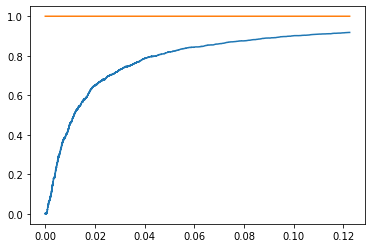

In [50]:
plt.plot(timindlog,mss**2/l2)#mss**2/(sss**2 + mss**2))
plt.plot(timindlog, np.ones(len(timindlog)))

In [51]:
def fun(ell,x):
    return (1/np.sqrt(4*np.pi*ell))*np.exp((-(x-ell)**2)/(4*ell))

In [52]:
timindlog[-1]

0.12259873770106511

In [53]:
timindlog[indi]

NameError: name 'indi' is not defined

In [58]:
indi = -2
timi = timindlog[indi]
muLF = l1[indi]/timindlog[indi]
counts, bins, ploo = plt.hist(l1s[:,indi], bins=50, density=True)
xx = np.linspace(min(bins),max(bins),1000)
ff = [fun(l1[indi], x) for x in xx]
plt.plot(xx,ff, color="red")

TypeError: list indices must be integers or slices, not tuple

In [59]:
mun = np.mean(l1s[:,-1])/timindlog[-1]

TypeError: list indices must be integers or slices, not tuple

In [274]:
mun

251.10752924859108

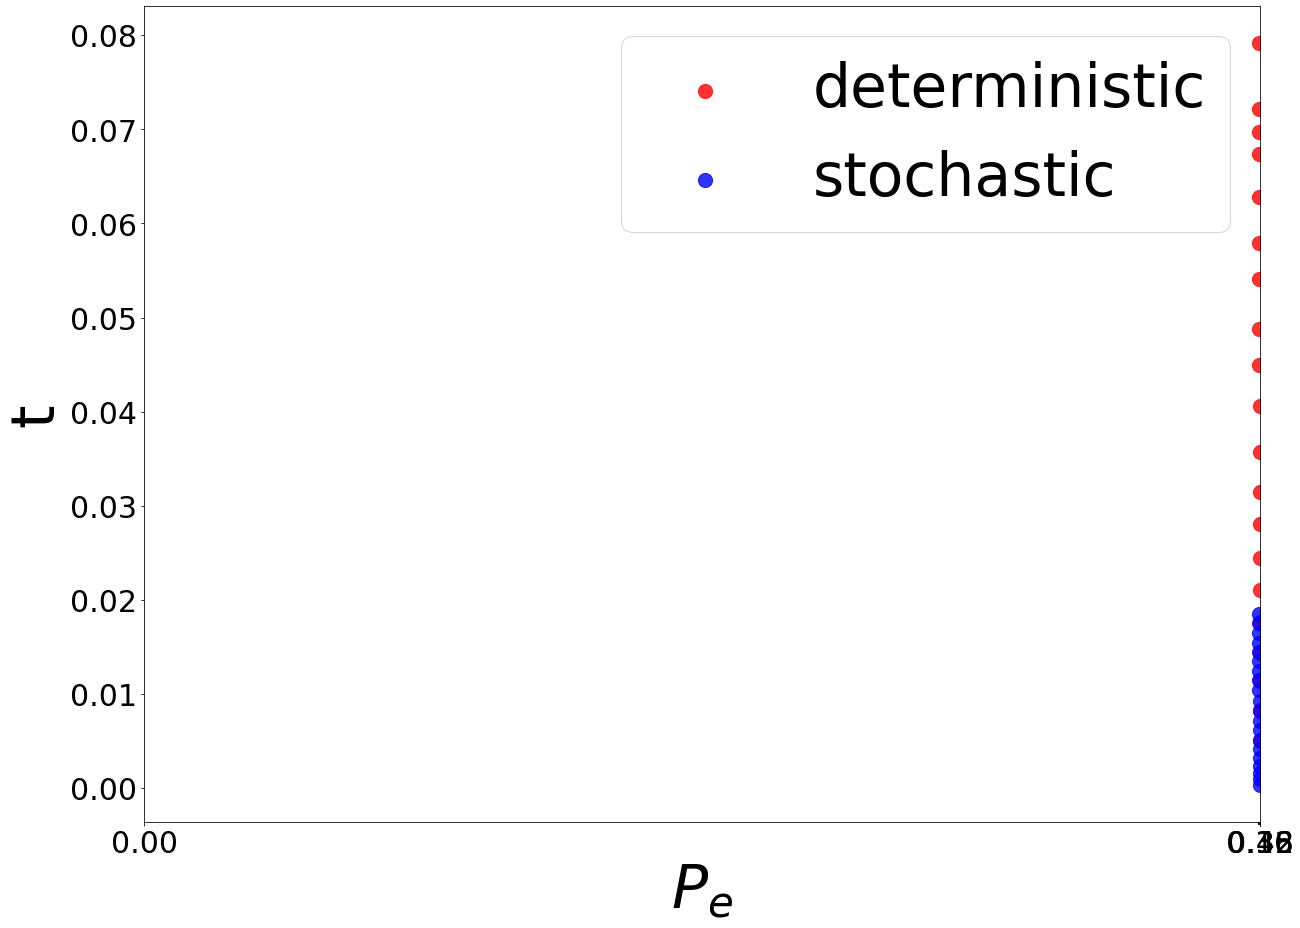

In [60]:

fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
lw=10
TS=30
A = 0
B= 20
ax.scatter(errs[A:B], times_alpha_to_errB[A:B],color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs[A:B], stoch[A:B] ,color="blue",s=200,  alpha=0.8,label="stochastic")

#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
ax.set_xscale("log")
ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"freq_adaptive_vs_det.pdf")




In [71]:
from numerics.utilities.misc import *

In [72]:
s1s, s0s = [], []
for itraj in tqdm(range(1,5*10**3)):
    try:

        s1, s0 = load_states(itraj=itraj, mode=mode, dtt=dt, total_time_in=total_time)
        s1s.append(s1)#append([log_lik_ratio[k] for k in indis])
        s0s.append(s0) #[k] for k in indis])
    except Exception:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:03<00:00, 1599.78it/s]


In [210]:
s1s = np.stack(s1s)
s0s = np.stack(s0s)

In [211]:
ssq1 = np.square(s1s)
ssq0 = np.square(s0s)

In [118]:
s1s.shape

(1000, 100000, 2)

In [200]:
np.sum(s0s[:,-1,0]*s1s[:,-1,0])/1000

981.3914170797503

In [209]:
s0s1 = np.einsum('btk,btk->bt',s0s[:,:,:], s1s[:,:,:])

In [212]:
s0s1m = np.mean(s0s1, axis=0)

In [235]:
s1_2m = np.sum(np.mean(ssq1, axis=0),axis=1)

In [236]:
s0_2m = np.sum(np.mean(ssq0, axis=0),axis=1)

In [237]:
deltaX = s0_2m + s1_2m - 2*s0s1m

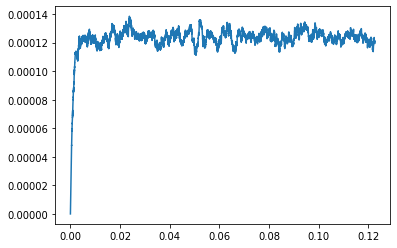

In [238]:
plt.plot(timindlog, deltaX)

In [242]:
1e-6/2

5e-07

In [240]:
deltaX[-1]/muLF

4.867023039836888e-07

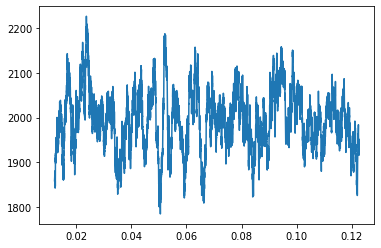

In [253]:
A = int(8*1e4)
B = -1
plt.plot(timindlog[A:B],s0_2m[A:B])

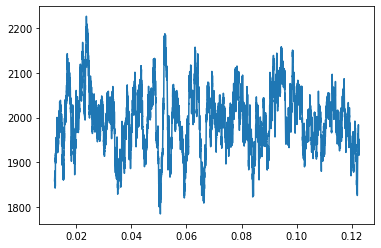

In [255]:
A = int(8*1e4)
B = -1
plt.plot(timindlog[A:B],s1_2m[A:B])

In [257]:
np.mean(s1_2m[A:B])

1995.9579322614647

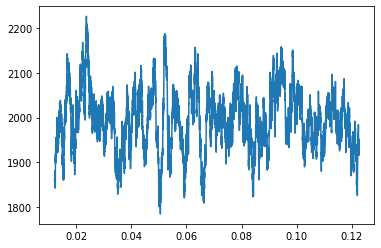

In [259]:
A = int(8*1e4)
B = -1
plt.plot(timindlog[A:B],s0s1m[A:B])

In [261]:
np.mean(s0s1m[A:B])

1995.9645324129497

In [263]:
x0_2smoo = np.mean(s1_2m[A:B])
x1_2smoo = np.mean(s1_2m[A:B])
x0x1_2smoo = np.mean(s0s1m[A:B])

In [265]:
Dx_2smoo = x0_2smoo + x1_2smoo - 2*x0x1_2smoo

In [ ]:
+ s1_2m - 2*s0s1m

In [273]:
muLF

248.8349625657871

In [266]:
Dx_2smoo/muLF

4.992717521878128e-07

In [267]:
x0_2smoo

1995.9712568007026

In [268]:
x1_2smoo

1995.9579322614647

In [269]:
x0x1_2smoo

1995.9645324129497

In [270]:
Dx_2smoo

0.00012423626776580932

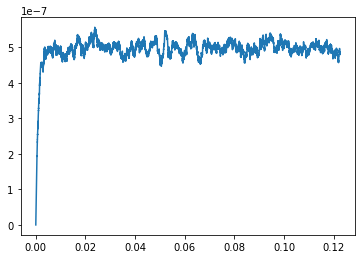

In [239]:
plt.plot(timindlog,deltaX/muLF)

In [228]:
deltaX/muLF

array([-6.13510539e-05, -6.13510539e-05, -6.13510539e-05, ...,
       -1.67819723e-01,  1.70259652e-02,  1.47740863e-01])

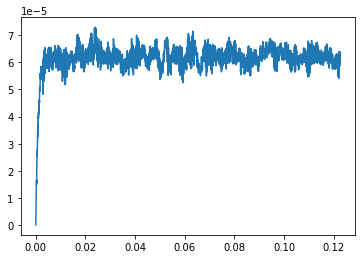

In [186]:
plt.plot(timindlog,deltaX)

In [195]:
(muLF/deltaX)[A:]

array([1.17019360e+09, 1.17019360e+09, 1.17019360e+09, ...,
       4.11586146e+06, 4.13350942e+06, 4.15495924e+06])

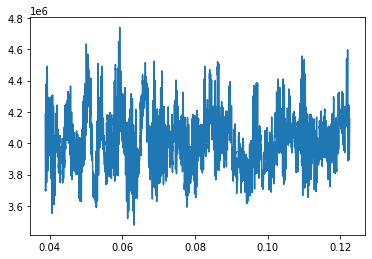

In [198]:
A = int(len(timindlog)-10000)
plt.plot(timindlog[A:],(muLF/deltaX)[A:])

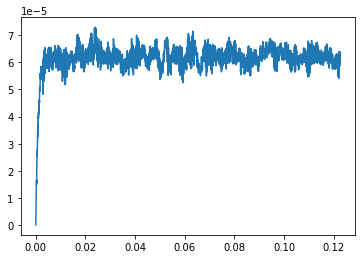

In [132]:
plt.plot(timindlog, deltaX)

In [134]:
deltaX[-1]*21e6

1257.6619690207735

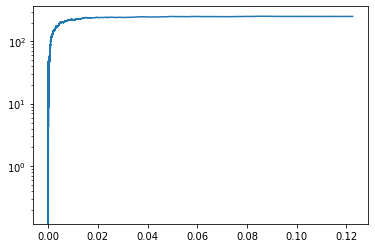

In [282]:
A = 0
B=-1
ax=plt.subplot(111)
ax.plot(timindlog[A:B], np.mean(l1s[:,A:B], axis=0)/timindlog[A:B])
ax.set_yscale("log")

In [288]:
A = np.argmin(np.abs(np.array(timindlog) - 0.04))

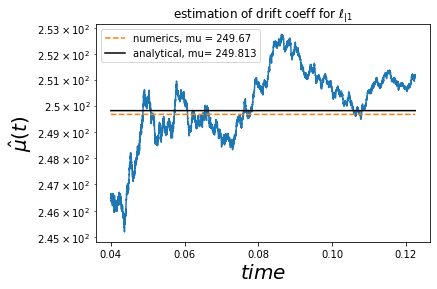

In [313]:
B=-1
ax=plt.subplot(111)
meann = np.mean(np.mean(l1s[:,A:B], axis=0)/timindlog[A:B])
ax.set_title("estimation of drift coeff for "+r'$\ell_{|1}$')
ax.plot(timindlog[A:B], np.mean(l1s[:,A:B], axis=0)/timindlog[A:B])
ax.plot(timindlog[A:B],np.ones(len(timindlog[A:B]))*meann,'--', label="numerics, mu = {}".format(np.round(meann,3)))
ax.plot(timindlog[A:B],np.ones(len(timindlog[A:B]))*249.813, '-', color="black",label="analytical, mu= {}".format(249.813))
ax.set_ylabel(r'$\hat{\mu}(t)$',size=20)
ax.set_xlabel(r'$time$',size=20)
ax.set_yscale("log")
ax.legend()

249.6700576821611

In [98]:
sstdq = np.std(ssq[:,:,0], axis=0)

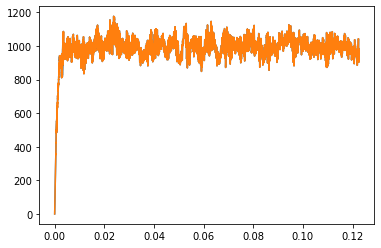

In [114]:
plt.plot(timindlog,mssq0)
plt.plot(timindlog,mssq1)

In [77]:
ss = s1s[:,:,0]

In [84]:
ms = np.mean(ss,axis=0)

In [86]:
ms[-1]

0.7392710204069113

In [80]:
ss.shape

(1000, 100000)

(array([ 1.,  0.,  0.,  2.,  1.,  1.,  5.,  1.,  4.,  5.,  9.,  9., 22.,
        11., 17., 28., 24., 35., 41., 34., 32., 49., 59., 40., 46., 54.,
        53., 43., 36., 38., 47., 38., 37., 29., 22., 21., 22., 23., 17.,
        10.,  4.,  9.,  5.,  4.,  3.,  3.,  1.,  1.,  2.,  2.]),
 array([-99.38039917, -95.47047184, -91.56054452, -87.65061719,
        -83.74068987, -79.83076254, -75.92083522, -72.01090789,
        -68.10098057, -64.19105325, -60.28112592, -56.3711986 ,
        -52.46127127, -48.55134395, -44.64141662, -40.7314893 ,
        -36.82156197, -32.91163465, -29.00170732, -25.09178   ,
        -21.18185268, -17.27192535, -13.36199803,  -9.4520707 ,
         -5.54214338,  -1.63221605,   2.27771127,   6.1876386 ,
         10.09756592,  14.00749325,  17.91742057,  21.8273479 ,
         25.73727522,  29.64720254,  33.55712987,  37.46705719,
         41.37698452,  45.28691184,  49.19683917,  53.10676649,
         57.01669382,  60.92662114,  64.83654847,  68.74647579,
         72.

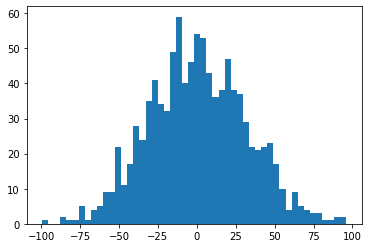

In [83]:
plt.hist(ss[:,-1], bins=50)

In [ ]:
bb = np.linspace(0,1000,1000)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(bb):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

bb = boundsB #np.linspace(0,1000,100)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(boundsB):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

In [ ]:
ll1={}
ll0={}
for k in range(1,5):
    ll1[k], ll0[k] = load_liks(itraj=k, mode="frequencies", dtt=dt, total_time_in=total_time)
    

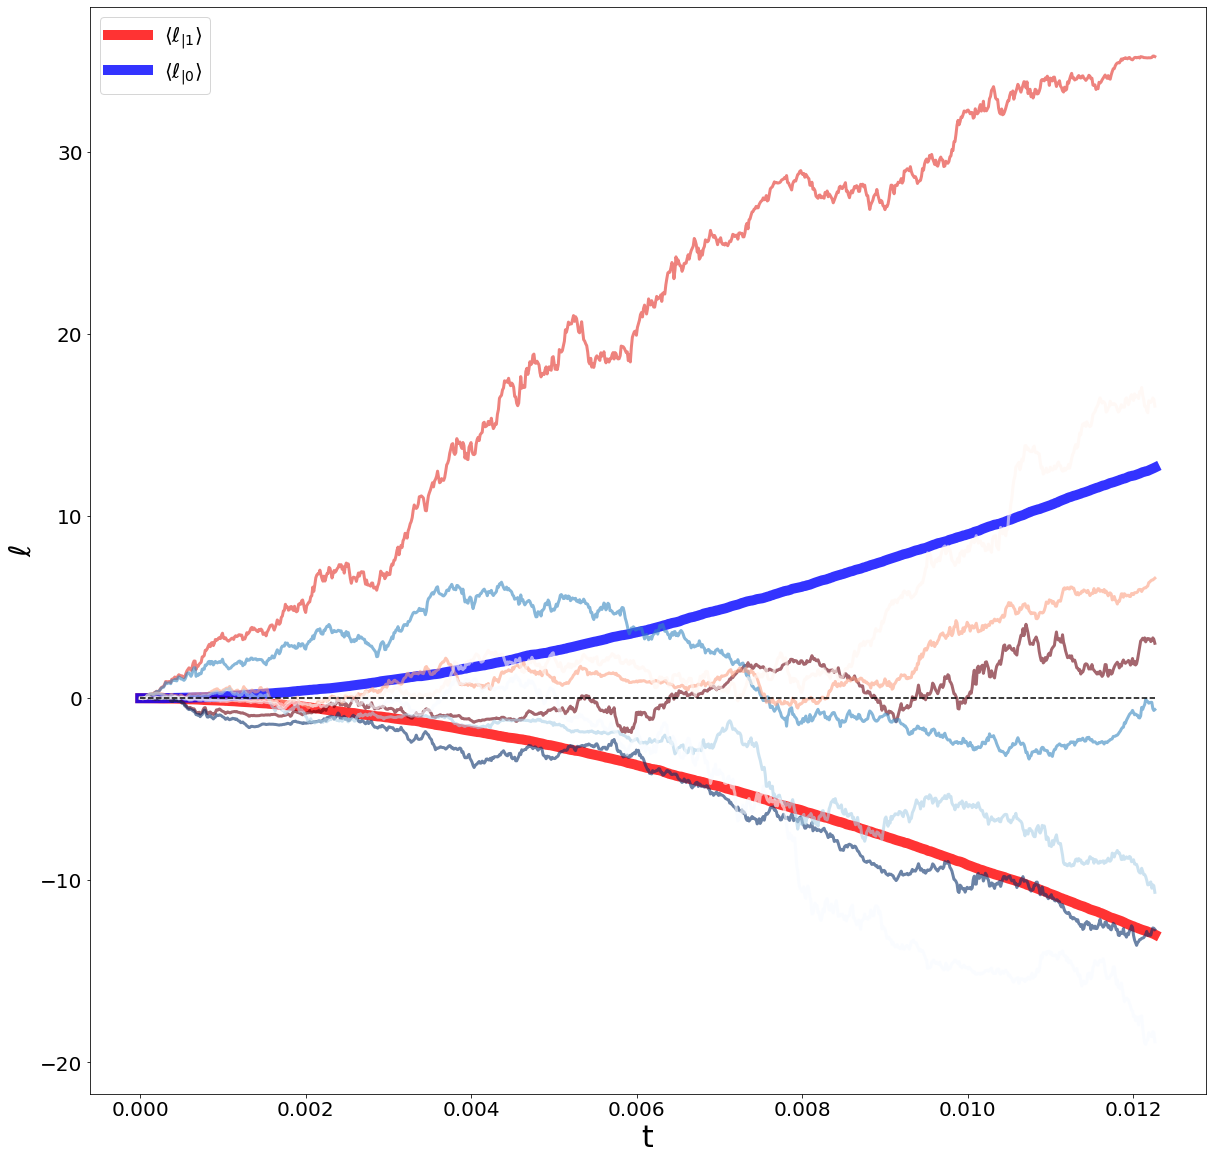

In [50]:
colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")
Ntraj = 4
Ltraj=3
LS=30
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]

jump = 100
plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.plot(times[::jump],l0[:-1][::jump], color="red", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|1} \rangle$')
ax.plot(times[::jump],l1[:-1][::jump], color="blue", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|0} \rangle$')
for ind,k in enumerate(range(1,5)):
    ax.plot(times[::jump],ll1[k][:-1][::jump], color=c1[ind], linewidth=Ltraj, alpha=0.6)
    ax.plot(times[::jump],ll0[k][:-1][::jump], color=c0[ind], linewidth=Ltraj, alpha=0.6)   
ax.plot(times[::jump], np.zeros(len(times))[::jump], '--', color="black")
ax.set_xlabel("t", size=LS)
ax.set_ylabel(r'$\ell$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(prop={"size":20})


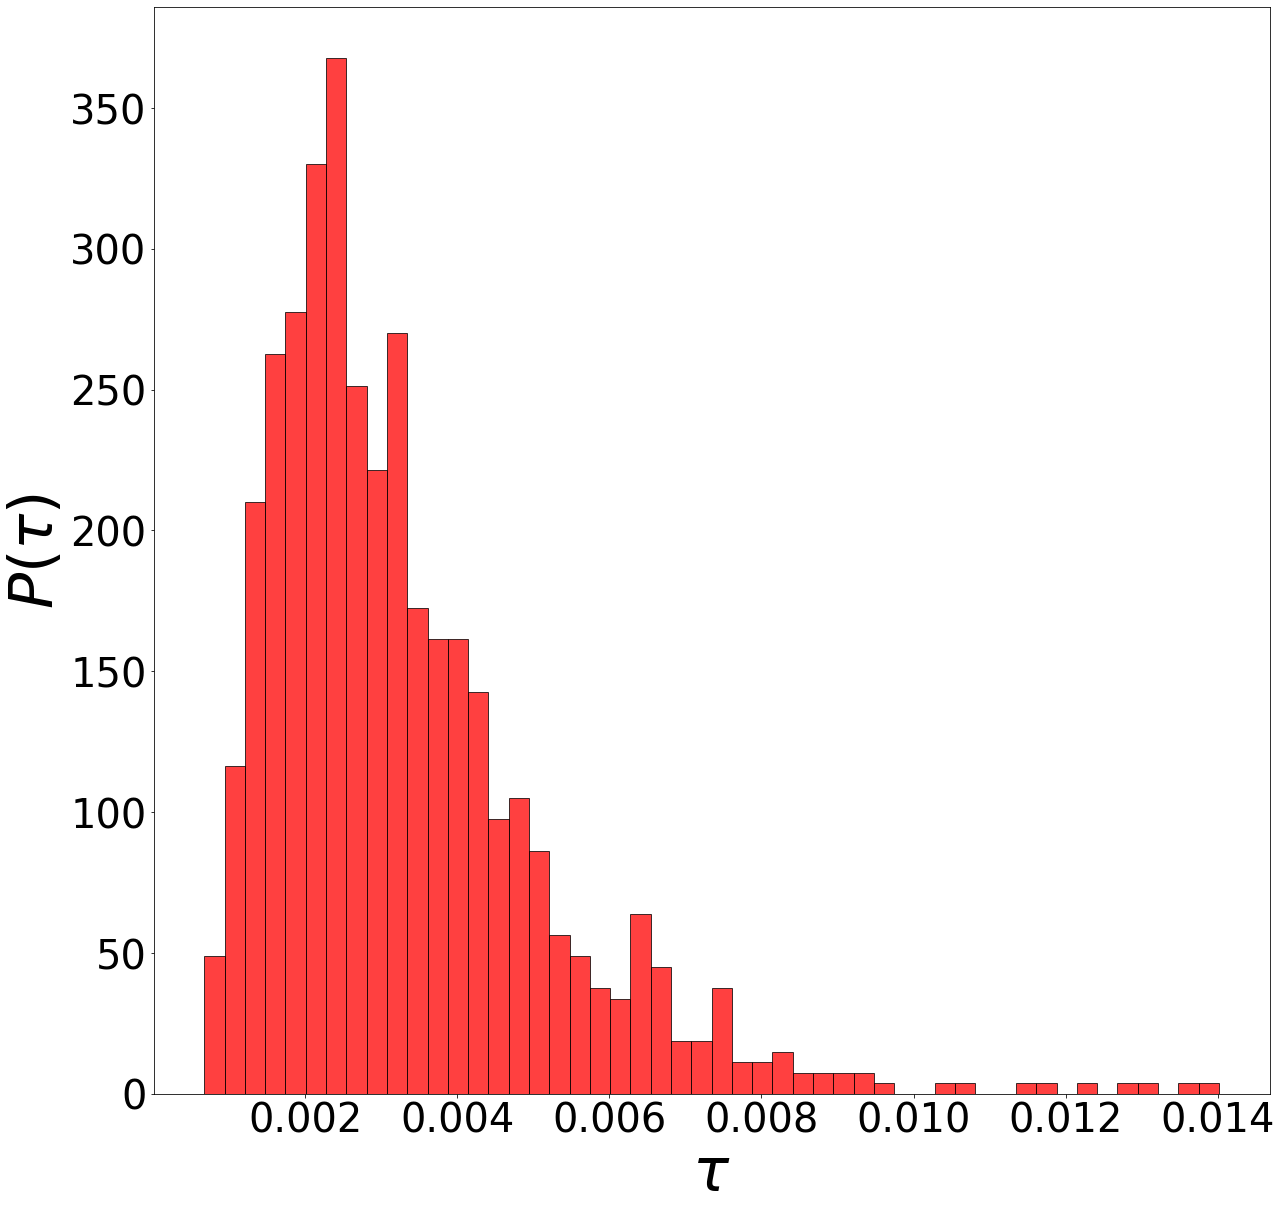

In [146]:
LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = -5
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [125]:
len(stop["_1"])

999

In [147]:
nn=0
for k in list(stop["_1"].values()):
    if k != []:
        nn+=1

In [148]:
nn

999